In [1]:
import torch.nn as nn
import torch
import os
import time
import pandas as pd
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from scipy.spatial import distance
from torch.utils.data import Dataset

In [2]:
HEIGHT, WIDTH = 720, 1280

In [3]:
def imshow(img, channels=3, height=360, width=640, title=None):
    img = img.float().to('cpu').numpy()
    print(img.shape)
    img = img.reshape((channels, height, width))
    img = img.transpose((1, 2, 0))
    plt.imshow(img)
    plt.show()

def display_bw_image(tensor_image, height=360, width=640):
    # Ensure the tensor is on CPU and detached from the computation graph
    tensor_image = tensor_image.cpu().detach()

    # Reshape the tensor to (360, 640)
    image = tensor_image.reshape(height, width)
    
    # Normalize the image to 0-255 range
    image = ((image - image.min()) / (image.max() - image.min()) * 255)
    
    # Convert to numpy array and cast to uint8
    image_np = image.numpy().astype(np.uint8)
    
    # Display the image
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')
    plt.show()

In [50]:
class trackNetDataset(Dataset):
    def __init__(self, mode, input_height=720, input_width=1280):
        self.path_dataset = './ball_dataset_clips'
        assert mode in ['train', 'val'], 'incorrect mode'
        self.data = pd.read_csv(os.path.join(self.path_dataset, 'gts/labels_with_gt.csv'))
        self.height = input_height
        self.width = input_width
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        clip_name, path_preprev, path_prev, path, x, y, path_gt = self.data.loc[idx, :]
        
        path = os.path.join(self.path_dataset, clip_name, 'images', path)
        path_prev = os.path.join(self.path_dataset, clip_name, 'images', path_prev)
        path_preprev = os.path.join(self.path_dataset, clip_name, 'images', path_preprev)
        path_gt = os.path.join(self.path_dataset, path_gt)
        if math.isnan(x):
            x = -1
            y = -1
        
        inputs = self.get_input(path, path_prev, path_preprev)
        outputs = self.get_output(path_gt)
        # print(path)
        
        return inputs, outputs, x, y
    
    def get_output(self, path_gt):
        img = cv2.imread(path_gt)
        img = cv2.resize(img, (self.width, self.height))
        img = img[:, :, 0]
        img = np.reshape(img, (self.width * self.height))
        return img
        
    def get_input(self, path, path_prev, path_preprev):
        # print(path, path_prev, path_preprev)
        img = cv2.imread(path)
        img = cv2.resize(img, (self.width, self.height))

        img_prev = cv2.imread(path_prev)
        img_prev = cv2.resize(img_prev, (self.width, self.height))
        
        img_preprev = cv2.imread(path_preprev)
        img_preprev = cv2.resize(img_preprev, (self.width, self.height))
        
        imgs = np.concatenate((img, img_prev, img_preprev), axis=2)
        imgs = imgs.astype(np.float32)/255.0

        imgs = np.rollaxis(imgs, 2, 0)
        return imgs

In [51]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=1, stride=1, bias=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=pad, bias=bias),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.block(x)

class BallTrackerNet(nn.Module):
    def __init__(self, out_channels=256):
        super().__init__()
        self.out_channels = out_channels

        self.conv1 = ConvBlock(in_channels=9, out_channels=64)
        self.conv2 = ConvBlock(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = ConvBlock(in_channels=64, out_channels=128)
        self.conv4 = ConvBlock(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = ConvBlock(in_channels=128, out_channels=256)
        self.conv6 = ConvBlock(in_channels=256, out_channels=256)
        self.conv7 = ConvBlock(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv8 = ConvBlock(in_channels=256, out_channels=512)
        self.conv9 = ConvBlock(in_channels=512, out_channels=512)
        self.conv10 = ConvBlock(in_channels=512, out_channels=512)
        self.ups1 = nn.Upsample(scale_factor=2)
        self.conv11 = ConvBlock(in_channels=512, out_channels=256)
        self.conv12 = ConvBlock(in_channels=256, out_channels=256)
        self.conv13 = ConvBlock(in_channels=256, out_channels=256)
        self.ups2 = nn.Upsample(scale_factor=2)
        self.conv14 = ConvBlock(in_channels=256, out_channels=128)
        self.conv15 = ConvBlock(in_channels=128, out_channels=128)
        self.ups3 = nn.Upsample(scale_factor=2)
        self.conv16 = ConvBlock(in_channels=128, out_channels=64)
        self.conv17 = ConvBlock(in_channels=64, out_channels=64)
        self.conv18 = ConvBlock(in_channels=64, out_channels=self.out_channels)

        self.softmax = nn.Softmax(dim=1)
        self._init_weights()
                  
    def forward(self, x, testing=False): 
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)    
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.ups1(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.ups2(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.ups3(x)
        x = self.conv16(x)
        x = self.conv17(x)
        x = self.conv18(x)
        out = x.reshape(batch_size, self.out_channels, -1)
        if not self.training:
            out = self.softmax(out)
        return out                       
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.uniform_(module.weight, -0.05, 0.05)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0) 

In [52]:
def train(model, train_loader, optimizer, device, epoch, max_iters=200):
    start_time = time.time()
    losses = []
    criterion = nn.CrossEntropyLoss()
    for iter_id, batch in enumerate(train_loader):
        optimizer.zero_grad()
        model.train()
        out = model(batch[0].float().to(device))
        gt = torch.tensor(batch[1], dtype=torch.long, device=device)
        loss = criterion(out, gt)

        loss.backward()
        optimizer.step()
        end_time = time.time()
        duration = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
        losses.append(loss.item())
        
        if iter_id > max_iters - 1:
            break
    print('train | epoch = {}, loss = {}'.format(epoch, np.mean(losses), duration))
    return np.mean(losses)

In [53]:
def validate(model, val_loader, device, epoch, min_dist=5):
    losses = []
    tp = [0, 0, 0, 0]
    fp = [0, 0, 0, 0]
    tn = [0, 0, 0, 0]
    fn = [0, 0, 0, 0]
    criterion = nn.CrossEntropyLoss()
    model.eval()
    for iter_id, batch in enumerate(val_loader):
        with torch.no_grad():
            out = model(batch[0].float().to(device))
            gt = torch.tensor(batch[1], dtype=torch.long, device=device)
            loss = criterion(out, gt)
            losses.append(loss.item())
            # metrics
            output = out.argmax(dim=1).detach().cpu().numpy()
            for i in range(len(output)):
                x_pred, y_pred = postprocess(output[i])
                x_gt = batch[2][i]
                y_gt = batch[3][i]
                vis = batch[4][i]
                if x_pred:
                    if vis != 0:
                        dst = distance.euclidean((x_pred, y_pred), (x_gt, y_gt))
                        if dst < min_dist:
                            tp[vis] += 1
                        else:
                            fp[vis] += 1
                    else:        
                        fp[vis] += 1
                if not x_pred:
                    if vis != 0:
                        fn[vis] += 1
                    else:
                        tn[vis] += 1
    print('val | epoch = {}, , loss = {}, tp = {}, tn = {}, fp = {}, fn = {} '.format(epoch,
                                                                                    round(np.mean(losses), 6),
                                                                                    sum(tp),
                                                                                    sum(tn),
                                                                                    sum(fp),
                                                                                    sum(fn)))
    eps = 1e-15
    precision = sum(tp) / (sum(tp) + sum(fp) + eps)
    vc1 = tp[1] + fp[1] + tn[1] + fn[1]
    vc2 = tp[2] + fp[2] + tn[2] + fn[2]
    vc3 = tp[3] + fp[3] + tn[3] + fn[3]
    recall = sum(tp) / (vc1 + vc2 + vc3 + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    print('precision = {}'.format(precision))
    print('recall = {}'.format(recall))
    print('f1 = {}'.format(f1))

    return np.mean(losses), precision, recall, f1


def postprocess(feature_map, scale=2):
    # np.set_printoptions(threshold=np.inf)
    # print(feature_map)
    feature_map *= 255
    feature_map = feature_map.reshape((HEIGHT, WIDTH))
    feature_map = feature_map.astype(np.uint8)
    ret, heatmap = cv2.threshold(feature_map, 127, 255, cv2.THRESH_BINARY)
    circles = cv2.HoughCircles(heatmap, cv2.HOUGH_GRADIENT, dp=1, minDist=1, param1=50, param2=2, minRadius=2,
                               maxRadius=7)
    x,y = None, None
    if circles is not None:
        if len(circles) == 1:
            x = circles[0][0][0]*scale
            y = circles[0][0][1]*scale
    return x, y

In [42]:
batch_size=2
exp_id='default'
num_epochs=200
lr=1.0
val_intervals=15
steps_per_epoch=200
model_path = './exps1/default/model_last.pt'

In [54]:
train_dataset = trackNetDataset('train', input_height=720, input_width=1280)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_dataset = trackNetDataset('val', input_height=720, input_width=1280)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [44]:
batch = next(iter(train_loader))

./ball_dataset_clips/clip_5/images/008.jpg ./ball_dataset_clips/clip_5/images/007.jpg ./ball_dataset_clips/clip_5/images/006.jpg
./ball_dataset_clips/clip_8/images/219.jpg ./ball_dataset_clips/clip_8/images/218.jpg ./ball_dataset_clips/clip_8/images/217.jpg


In [46]:
x, y, _, _ = batch

In [47]:
x.shape, y.shape

(torch.Size([2, 9, 720, 1280]), torch.Size([2, 921600]))

(3, 720, 1280)


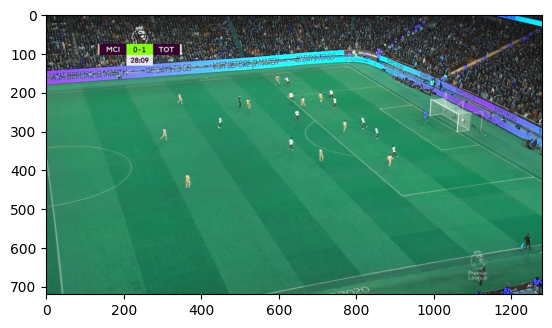

In [48]:
imshow(x[0][:3], height=720, width=1280)

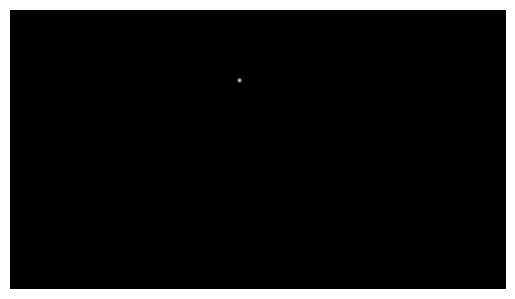

In [49]:
display_bw_image(y[0], height=720, width=1280)

In [55]:
device = 'cuda'
model = BallTrackerNet()
model = model.to(device)

exps_path = './exps1/{}'.format(exp_id)
tb_path = os.path.join(exps_path, 'plots')
if not os.path.exists(tb_path):
    os.makedirs(tb_path)
model_last_path = os.path.join(exps_path, 'model_last.pt')
model_best_path = os.path.join(exps_path, 'model_best.pt')
# model.load_state_dict(torch.load(model_last_path, map_location=torch.device(device)))

optimizer = optim.Adadelta(model.parameters(), lr=lr)
val_best_metric = 0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, device, epoch, steps_per_epoch)
    print('train loss = {}'.format(train_loss))

    if (epoch >= 0) & (epoch % val_intervals == 0):
        # val_loss, precision, recall, f1 = validate(model, val_loader, device, epoch)
        # print('val loss = {}'.format(val_loss))
        # if f1 > val_best_metric:
        #     val_best_metric = f1
        #     torch.save(model.state_dict(), model_best_path)           
        torch.save(model.state_dict(), model_last_path)

/tmp/ipykernel_87/2798114967.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt = torch.tensor(batch[1], dtype=torch.long, device=device)


train | epoch = 0, loss = 4.863324409693628
train loss = 4.863324409693628
train | epoch = 1, loss = 3.085605769608151
train loss = 3.085605769608151
train | epoch = 2, loss = 1.3993400883911855
train loss = 1.3993400883911855
train | epoch = 3, loss = 0.5052142312277609
train loss = 0.5052142312277609
train | epoch = 4, loss = 0.20385673449407168
train loss = 0.20385673449407168
train | epoch = 5, loss = 0.09350622608442212
train loss = 0.09350622608442212
train | epoch = 6, loss = 0.046373326312843244
train loss = 0.046373326312843244
train | epoch = 7, loss = 0.02512383552740759
train loss = 0.02512383552740759
train | epoch = 8, loss = 0.015648699379456576
train loss = 0.015648699379456576
train | epoch = 9, loss = 0.010983117763416388
train loss = 0.010983117763416388
train | epoch = 10, loss = 0.008611115747460383
train loss = 0.008611115747460383
train | epoch = 11, loss = 0.00622906346819294
train loss = 0.00622906346819294
train | epoch = 12, loss = 0.004157156162241947
train 

/tmp/ipykernel_101/1778925403.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt = torch.tensor(batch[1], dtype=torch.long, device='cuda')


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


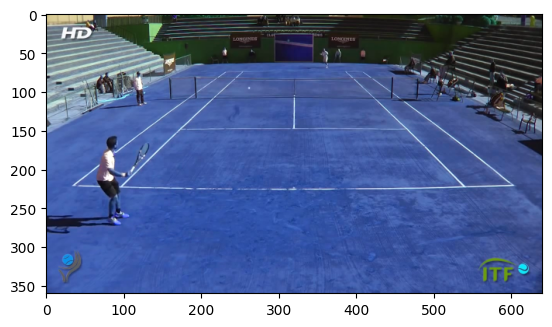

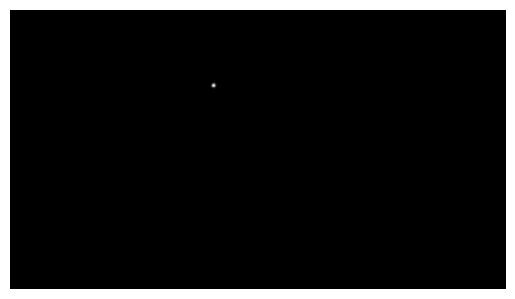

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


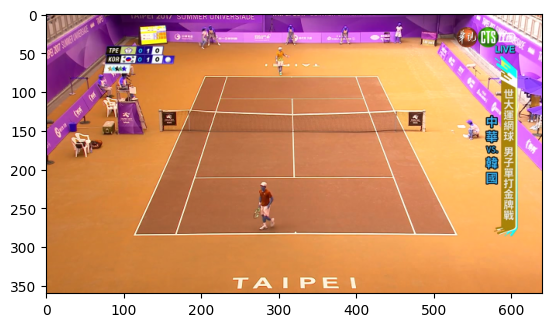

/tmp/ipykernel_101/3898514236.py:20: RuntimeWarning: invalid value encountered in cast
  image_np = image.numpy().astype(np.uint8)


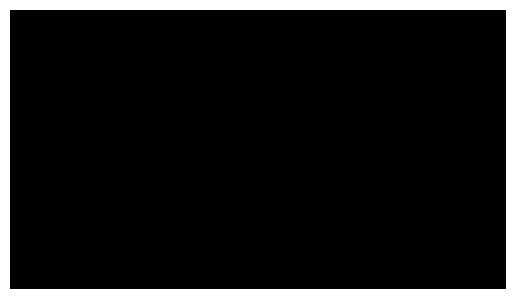

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


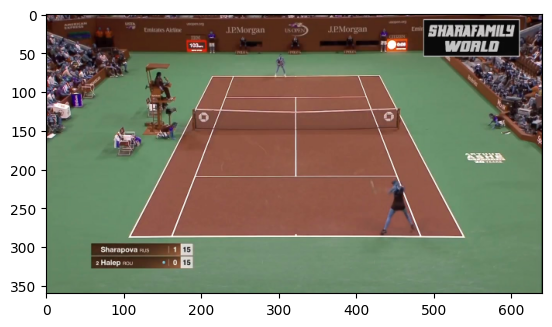

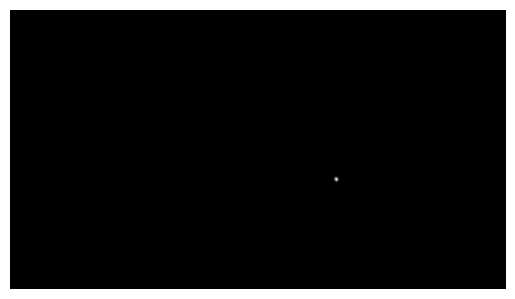

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


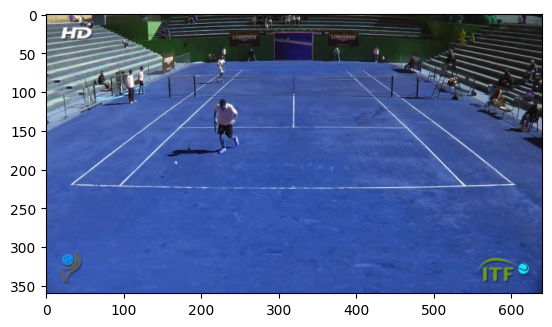

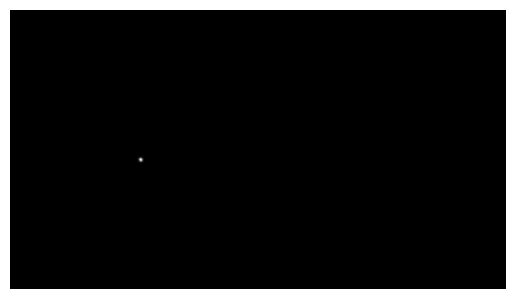

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


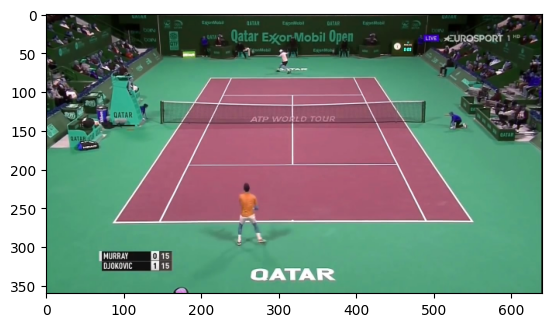

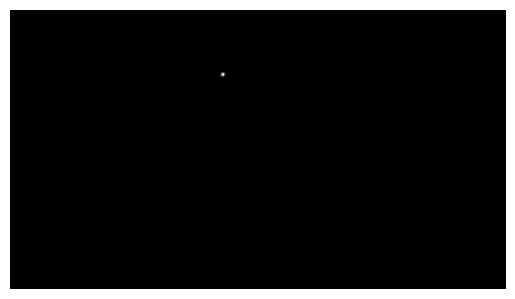

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


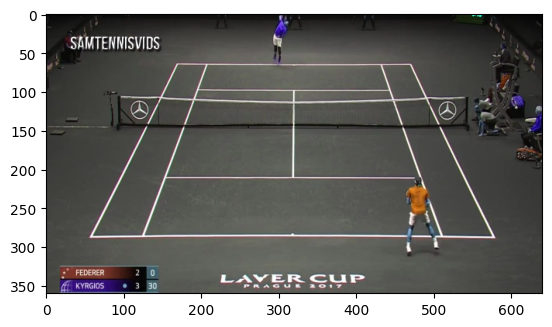

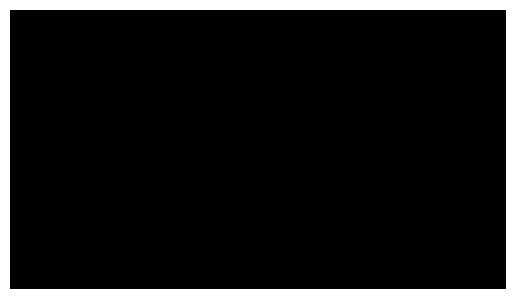

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


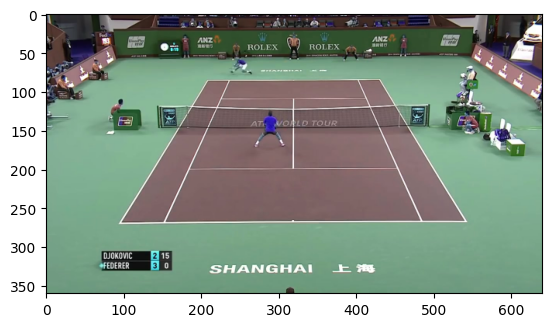

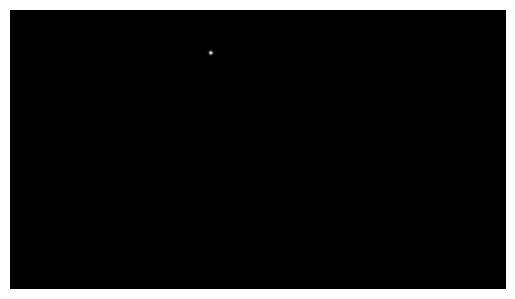

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


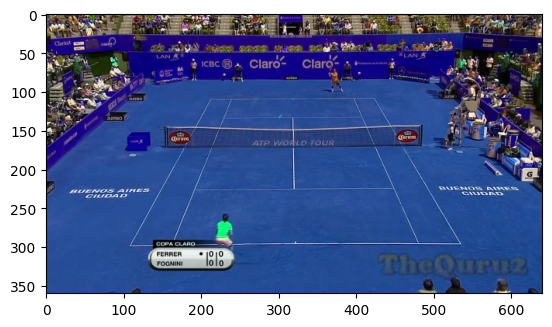

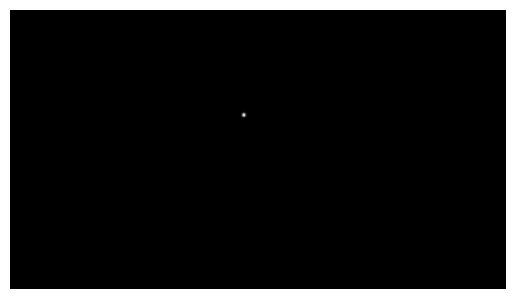

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


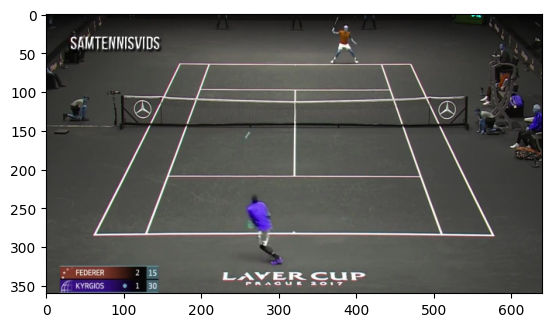

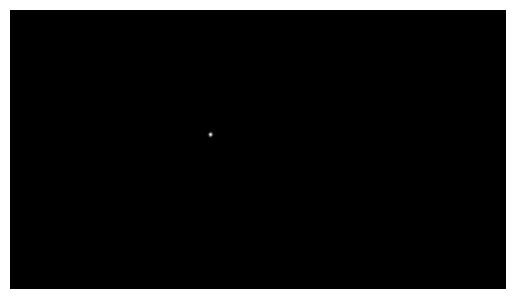

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


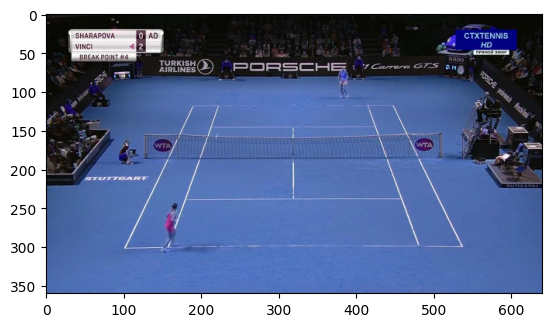

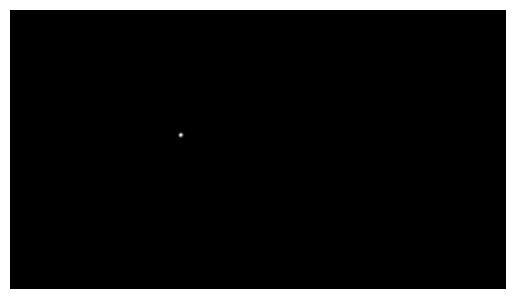

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
(3, 360, 640)


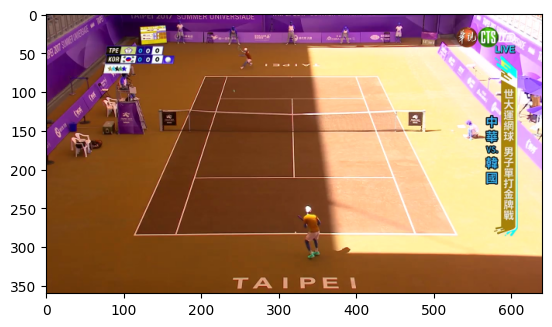

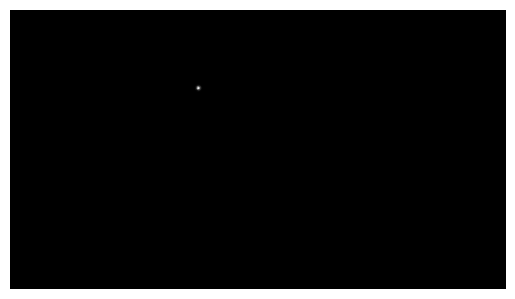

In [23]:
for iter_id, batch in enumerate(val_loader):
    if iter_id > 10:
        break
    # print(len(batch), len(batch[0]), batch[0].shape, batch[1].shape)
    with torch.no_grad():
        out = model(batch[0].float().to('cuda'))
        gt = torch.tensor(batch[1], dtype=torch.long, device='cuda')
        output = out.argmax(dim=1).detach()
        print(output)
        # print(out.shape, output.shape)
        #     img = batch[0][0][:3]
        #     print(out, out.shape)
        #     for x in output[0]:
        #         if x != 0:
        #             print(x)
        # Visualizing the input images
        # print(gt.shape, out.shape, output.shape)
        img = batch[0][0][:3]
        imshow(img)

        display_bw_image(output[0])